### Considered model: four-bar linkage (= two link manipulator + one link manipulator + rigid coupling)


This Notebook depends on symbtools >=0.2.5

→ `pip install --upgrade symbtools`





In [42]:
%load_ext ipydex.displaytools
%matplotlib inline

import sys
# to load assimulo under wsl2
sys.path.append('/home/kwrede/miniconda3/lib/python3.8/site-packages')

import os
import sympy as sp
import numpy as npy  # we need `np` later 
from sympy import sin, cos, pi
from sympy.interactive import printing

# using wredsen's symbtools fork, assuming repos SA-Wrede and symbtools share the same parent directory
sys.path.append('../../symbtools/')
import symbtools as st
import symbtools.modeltools as mt
from symbtools.modeltools import Rz # Rotationsmatrix in the xy plane (c, -s; s, c)

import scipy.integrate as sc_integrate
from scipy.optimize import fmin
import matplotlib.pyplot as pl
from assimulo.solvers import ODASSL as SOLVER # Imports the solver ODASSL from Assimulo
from assimulo.problem import Overdetermined_Problem # Imports the problem formulation from Assimulo
import ipydex
plt = pl

printing.init_printing(1)

The ipydex.displaytools extension is already loaded. To reload it, use:
  %reload_ext ipydex.displaytools


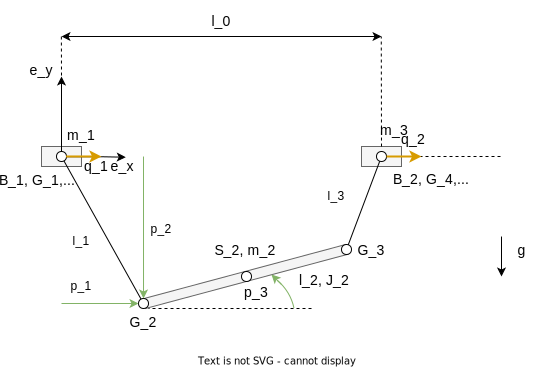

In [43]:
from IPython.display import Image
from IPython.core.display import SVG
SVG(filename='double_crane_w1_angle_diagram.svg')

In [44]:
t = sp.Symbol('t')  # time variable

# coordinates
np = 3
nq = 2
n = np + nq
pp = st.symb_vector("p1:{0}".format(np+1))
qq = st.symb_vector("q1:{0}".format(nq+1))


aa = st.symb_vector("a1:{0}".format(nq+1)) ##:T

ttheta = st.row_stack(pp, qq) ##:T
tthetad = st.time_deriv(ttheta, ttheta) ##:T
tthetadd = st.time_deriv(ttheta, ttheta, order=2) ##:T
st.make_global(ttheta, tthetad, tthetadd)

aa.T := [a₁  a₂]

---

ttheta.T := [p₁  p₂  p₃  q₁  q₂]

---

tthetad.T := [ṗ₁  ṗ₂  ṗ₃  q̇₁  q̇₂]

---

tthetadd.T := [p̈₁  p̈₂  p̈₃  q̈₁  q̈₂]

---

In [45]:
params = sp.symbols('s2, m1, m2, m3, J1, J2, J3, d1, d4, l0, l1, l2, l3, g')
st.make_global(params)

# ttau = sp.symbols('tau')
tau1, tau2 = ttau = st.symb_vector("tau1, tau2")


Specify the geometry (joints G and centers of masses S)

In [46]:
# uni vectors

ex = sp.Matrix([1, 0]) 
ey = sp.Matrix([0, 1]) 

# Basis 1 and 2
S1 = G1 = B1 = sp.Matrix([q1, 0]) ##:
S3 = G4 = B2 = sp.Matrix([l0 + q2, 0]) ##:

# joints 2 and 3
G2 = sp.Matrix([p1, p2]) ##:
G3 = G2 + Rz(p3)*ex*l2 ##:

# center of mass of load
S2 = G2 + Rz(p3)*ex*s2 ##:

# Time derivative
Sd1, Sd2, Sd3 = st.col_split(st.time_deriv(st.col_stack(S1, S2, S3), ttheta))

B1 := ⎡q₁⎤
⎢  ⎥
⎣0 ⎦

---

B2 := ⎡l₀ + q₂⎤
⎢       ⎥
⎣   0   ⎦

---

G2 := ⎡p₁⎤
⎢  ⎥
⎣p₂⎦

---

G3 := ⎡l₂⋅cos(p₃) + p₁⎤
⎢               ⎥
⎣l₂⋅sin(p₃) + p₂⎦

---

S2 := ⎡p₁ + s₂⋅cos(p₃)⎤
⎢               ⎥
⎣p₂ + s₂⋅sin(p₃)⎦

---

In [47]:
# kinetic energy

T1 = (m1/2 * Sd1.T*Sd1)[0] 
T2 = (m2/2 * Sd2.T*Sd2)[0] + J2/2 * pdot3**2
T3 = (m3/2 * Sd3.T*Sd3)[0]

T = T1 + T2 + T3 ##:

# potential energy, for l1 <= l2
V = m2*g*(l1 + s2 + S2[1]) ##:

---

---

In [48]:
###### mu1, mu2 = mmu = st.symb_vector("mu1, mu2")

# dissipation included here!
external_forces = [0 , 0, 0, tau1, tau2] #-d1*qdot1, -d4*qdot2

mod = mt.generate_symbolic_model(T, V, ttheta, external_forces, constraints=[(p1-q1)**2 + p2**2 - l1**2, (G3[0]-l0-q2)**2 + G3[1]**2 -l3**2])


In [49]:
mod.eqns

⎡                                                                             
⎢                               -2⋅λ₁⋅(p₁ - q₁) + 2⋅λ₂⋅(l₀ - l₂⋅cos(p₃) - p₁ +
⎢                                                                             
⎢                                                                             
⎢                                     g⋅m₂ - 2⋅λ₁⋅p₂ - 2⋅λ₂⋅(l₂⋅sin(p₃) + p₂) 
⎢                                                                             
⎢                                                                             
⎢J₂⋅p̈₃ + g⋅m₂⋅s₂⋅cos(p₃) - 2⋅l₀⋅l₂⋅λ₂⋅sin(p₃) + 2⋅l₂⋅λ₂⋅p₁⋅sin(p₃) - 2⋅l₂⋅λ₂⋅
⎢                                                                             
⎢                                                                 2⋅λ₁⋅(p₁ - q
⎢                                                                             
⎣                                                       -2⋅λ₂⋅(l₀ - l₂⋅cos(p₃)

          ⎛                        2           ⎞   

### Creation of DAE System

In [50]:
parameter_values = list(dict(s2=1/4, m1=1/2, m2=1, m3=1/2, J2=1/12, d1=1, d4=1, l0=1, l1=1, l2=0.5, l3=1, g=9.81).items()) ##:

parameter_values := [('s2', 0.25),
 ('m1', 0.5),
 ('m2', 1),
 ('m3', 0.5),
 ('J2', 0.08333333333333333),
 ('d1', 1),
 ('d4', 1),
 ('l0', 1),
 ('l1', 1),
 ('l2', 0.5),
 ('l3', 1),
 ('g', 9.81)]

---

#### Visualization of kinematics for debugging and placement of initial values

In [51]:
# matrix of joints
joints = sp.Matrix.hstack(G1, G2, G3, G4) ##:
joints = joints.subs(parameter_values)
# condition for closing loop of kinematic chain (x and y)
constraints = mod.constraints ##:
constraints = constraints.subs(parameter_values)

# numerical functions for joints and constraints
constraints_func = sp.lambdify(ttheta, constraints, modules="numpy")
joints_func = sp.lambdify(ttheta, joints, modules="numpy")

# cost function, theta_var: variable coordinates to be optimized, theta_const: constant coordinate (manipulated by slider later)
def cost_func(theta_var, theta_const):   
    err = constraints_func(*theta_var, theta_const[0], theta_const[1], theta_const[2])
    return err[0]**2 + err[1]**2 # squared error

joints := ⎡q₁  p₁  l₂⋅cos(p₃) + p₁  l₀ + q₂⎤
⎢                                ⎥
⎣0   p₂  l₂⋅sin(p₃) + p₂     0   ⎦

---

constraints := ⎡                     2     2            2                 ⎤
⎢                 - l₁  + p₂  + (p₁ - q₁)                  ⎥
⎢                                                          ⎥
⎢    2                    2                               2⎥
⎣- l₃  + (l₂⋅sin(p₃) + p₂)  + (-l₀ + l₂⋅cos(p₃) + p₁ - q₂) ⎦

---

In [52]:
%matplotlib inline

init_theta = []

from ipywidgets import interact
@interact(p3=(-2, 2, .1), q1=(-1, 1, .1), q2=(-1, 1, .1))
def plot_func(p3, q1, q2):
    res = fmin(cost_func, x0=[0.25, -0.7], args=([p3, q1, q2],), disp=0, ftol=1e-15)

    # dependent coordinates
    p1, p2 = res
    jc = joint_coords = joints_func(p1, p2, p3, q1, q2)

    plt.plot(jc[0, :], jc[1, :], "ok", ms=7)
    plt.plot(jc[0, :], jc[1, :], "b-")
    plt.axis("equal")
    plt.axis([-0.5, 1.4, -1.5, 0.5])
    
    init_theta[:] = [p1, p2, p3, q1, q2]
    const_err = constraints_func(*init_theta)
    
    str_coords = ( f'Initial Values:\n'
                   f'p1: {p1}\n'
                   f'p2: {p2}\n'
                   f'p3: {p3}\n'
                   f'q1: {q1}\n'
                   f'q2: {q2}\n'
                   f'error of constraints: \n {const_err} \n')
    print(str_coords)

interactive(children=(FloatSlider(value=0.0, description='p3', max=2.0, min=-2.0), FloatSlider(value=0.0, desc…

#### DAE system for simulation

In [53]:
dae = mod.calc_dae_eq(parameter_values)
dae.generate_eqns_funcs()

In [54]:
# degrees of freedom of DAE system
dae.ndof

In [55]:
dae.yy ##:T
dae.yyd ##:T

(dae.yy).T := [p₁  p₂  p₃  q₁  q₂  ṗ₁  ṗ₂  ṗ₃  q̇₁  q̇₂  λ₁  λ₂]

---

(dae.yyd).T := [ẏ₁  ẏ₂  ẏ₃  ẏ₄  ẏ₅  ẏ₆  ẏ₇  ẏ₈  ẏ₉  ẏ₁₀  ẏ₁₁  ẏ₁₂]

---

In [56]:
dae.eqns

⎡                                                                 -ṗ₁ + ẏ₁  
⎢                                                                             
⎢                                                                 -ṗ₂ + ẏ₂  
⎢                                                                             
⎢                                                                 -ṗ₃ + ẏ₃  
⎢                                                                             
⎢                                                                 -q̇₁ + ẏ₄  
⎢                                                                             
⎢                                                                 -q̇₂ + ẏ₅  
⎢                                                                             
⎢                                                                             
⎢                      -2⋅λ₁⋅(p₁ - q₁) + 2⋅λ₂⋅(-p₁ + q₂ - 0.5⋅cos(p₃) + 1) - 0
⎢                                                   

In [57]:
dae.mod.tau

⎡τ₁⎤
⎢  ⎥
⎣τ₂⎦

In [98]:
# define open loop control function for input
def new_input_func(yy, t):
    u1 = 1*yy[1]
    u2 = 1*yy[1]
    return [u1, u2]

# set as input of DAE system
dae.input_func = new_input_func ##:

(dae.input_func) := <function __main__.new_input_func(yy, t)>

---

In [99]:
dae.constraints_func(*init_theta) ##:

#yy0, yyd0 = dae.calc_consistent_init_vals(p3=init_theta[2], q1=init_theta[3], q2=init_theta[4], _ftol=1e-9) ##:
yy0, yyd0 = dae.calc_consistent_init_vals(p1=init_theta[0], p2=init_theta[1], p3=init_theta[2], _ftol=1e-9) ##:

t0 = 0

dae.model_func(t0, yy0, yyd0) ##:

# check if all values are almost zero (-> initial values fulfill the model)
#TODO: atol pretty high, why?
assert npy.allclose(dae.model_func(t0, yy0, yyd0), 0)

(dae.constraints_func(*init_theta)) := array([-2.16291502e-08,  3.22383453e-10])

---

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 38
         Function evaluations: 73
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 36
         Function evaluations: 73


(yy0, yyd0) := (array([ 2.49999978e-01, -9.68245831e-01,  0.00000000e+00, -4.17735925e-08,  6.72986444e-11,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00, -2.52077323e+00, -2.22847257e+00]),
 array([ 0.        ,  0.        ,  0.        ,  0.        ,  0.        , -0.14615033, -0.18859677, -1.69811333,  0.58428176, -4.16496443, -0.        , -0.        ]))

---

(dae.model_func(t0, yy0, yyd0)) := array([ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  8.32667268e-17,  1.77635684e-15,  0.00000000e+00, -1.11022302e-16,  0.00000000e+00, -5.55111512e-16,  0.00000000e+00])

---

In [100]:
model = Overdetermined_Problem(dae.model_func, yy0, yyd0, t0)
model.name = 'gantry crane'

# indicate which components of y are differential (1) and which are purely algebraic (0)
# model.algvar = dae.diff_alg_vars ##:

sim = SOLVER(model)
# sim.suppress_alg = True #Necessary to set to True for >1 index problem

# values <= 30 produce lots of output
sim.verbosity = 0

In [101]:
tfinal = 10.0        # Specify the final time
ncp = 500            # Number of communication points (number of return points)

# takes about 48 seconds
tt_sol, yy_sol, yyd_sol = sim.simulate(tfinal, ncp) 

No initialization defined for the problem.
No finalization defined for the problem.
Final Run Statistics: gantry crane 

 Number of steps                           : 575
 Number of function evaluations            : 1165
 Number of Jacobian evaluations            : 19
 Number of error test failures             : 1
 Number of nonlinear convergence failures  : 0

Solver options:

 Solver                  : ODASSL 
 Tolerances (absolute)   : 1e-06
 Tolerances (relative)   : 1e-06

Simulation interval    : 0.0 - 10.0 seconds.
Elapsed simulation time: 0.9420434910007316 seconds.


In [102]:
ttheta_sol = yy_sol[:, :mod.dae.ntt]
ttheta_d_sol = yy_sol[:, mod.dae.ntt:mod.dae.ntt*2]

Text(0.5, 1.0, 'dot theta')

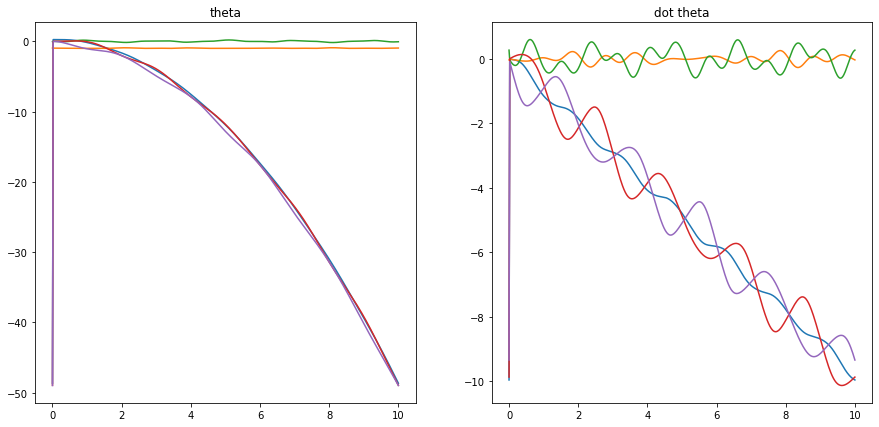

In [103]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 7)); plt.sca(ax1)

ax1.plot(tt_sol, ttheta_sol)
ax1.set_title("theta")

ax2.plot(tt_sol, ttheta_d_sol)
ax2.set_title("dot theta")

####  Visualization and Animation

In [104]:
joint_pos_expr = st.col_stack(G1, G2, G3, G4).subs(parameter_values) ##:
joint_pos_func = st.expr_to_func(mod.tt, joint_pos_expr, keep_shape=True)

joint_pos_expr := ⎡q₁  p₁  p₁ + 0.5⋅cos(p₃)  q₂ + 1⎤
⎢                                ⎥
⎣0   p₂  p₂ + 0.5⋅sin(p₃)    0   ⎦

---

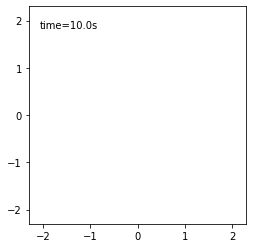

In [105]:
import matplotlib.animation as animation
from IPython.display import HTML

fig = pl.figure() 
ax = fig.add_subplot(111, autoscale_on=False, xlim=(-2.3,2.3), ylim=(-2.3,2.3))
ax.set_aspect('equal')

line, = ax.plot([],[],'o-', lw=2)
time_template = 'time=%.1fs'
time_text = ax.text(0.05, 0.9, '', transform=ax.transAxes)
dt = tt_sol[1] - tt_sol[0]


def init():
    line.set_data([],[])
    time_text.set_text('')
    return line, time_text

l1 =1.0

def animate(i):
    xx, yy = joint_pos_func(*ttheta_sol[i, :])
    
    line.set_data(xx,yy)
    time_text.set_text(time_template%(i*dt))
    
    return line, time_text


ani = animation.FuncAnimation(fig, animate, range(ttheta_sol.shape[0]), interval=tt_sol[-1]*3, blit=True, init_func=init)


# this animation is nice but results in a big notebook file which is unwanted for publication in the repo
HTML(ani.to_jshtml())





*Preliminary Conclusion*

→ Behavior looks more or less realistic - up to the configurations where $p_1$ is an integer multiple of $\pi$ (joint is fully streched or fully bended). Probably there are singularities.

In [27]:
# this might need to be adapted on other systems

plt.rcParams["animation.codec"] = "libvpx-vp9"  # codec for webm
plt.rcParams['animation.ffmpeg_path'] = '/usr/bin/ffmpeg'
writer = animation.FFMpegWriter(fps=30)
ani.save("gantry_crane.webm", writer=writer)

In [28]:
%%HTML
<video width="320" height="240" controls>
  <source src="gantry_crane.webm" type="video/webm">
</video>